#### Train a Random Forest model with ApacheJIT dataset.

#### Import libraries.

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import time
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


#### Load dataset.

In [2]:

df = None

dtypes = {"commit_id": "str", "project" : "str", "buggy" : "str", "fix" : "str", "year" : "str", "author_date" : "str",
          "la" : "int16", "ld" : "int16", "nf" : "int16", "nd" : "int16", "ns" : "int16", "ent" : "float64",
          "ndev" : "float64", "age" : "float64", "nuc" : "float64", "aexp" : "int16", "arexp" : "float64", "asexp" : "float64"}

try:
    print("\nStart loading CSV file...")
    df = pd.read_csv("../dataset/java/apachejit_total.csv", sep = ",", dtype = dtypes)
    print("\nFinish loading CSV file...")
except Exception as e:
    print("\nFail to load CSV file.")
    print("Error: {}".format(e))



Start loading CSV file...

Finish loading CSV file...


#### Check for dataset shape.

In [3]:

df.shape


(106674, 18)

#### Remove unnecessary features from the dataset and show class identification.

In [4]:

df.drop(columns = ["commit_id", "project", "fix", "year", "author_date"], inplace = True)
le = LabelEncoder()
df.loc[:, ["buggy"]] = le.fit_transform(df["buggy"])
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"Dataset classes: {mapping}")


Dataset classes: {'False': 0, 'True': 1}


#### Perform oversampling of the dataset samples and train the Random Forest model.

In [5]:

feature_names = ["la", "ld", "nf", "nd", "ns", "ent", "ndev", "age", "nuc", "aexp", "arexp", "asexp"]

X = df.loc[:, feature_names].values
y = df.loc[:, ["buggy"]].values.astype(int)

transformer = RobustScaler().fit(X)
X_rbs = transformer.transform(X)

print("\nStart generating SMOTE...")
sm = SMOTE(random_state = 42)
X_array_res, y_array_res = sm.fit_resample(X_rbs, y)
print("{} samples after SMOTE.".format(len(y_array_res)))
print("Finish generating SMOTE.")
print(f"Class distribution after SMOTE: {Counter(y_array_res)}")

X_train, X_test, y_train, y_test = train_test_split(X_array_res, y_array_res, test_size = 0.2, stratify = y_array_res, random_state = 42)
print("Number of samples for training: {}".format(len(X_train)))
print("Number of samples for test: {}".format(len(X_test)))

start_time = time.time()
print("\nStarting training at: ", time.strftime("%H:%M:%S", time.localtime()))
model = RandomForestClassifier(n_estimators = 100, max_depth = 5, random_state = 42)
model.fit(X_train, y_train)
elapsed_seconds = time.time() - start_time
print("\nTime taken for training: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_seconds)))



Start generating SMOTE...
156870 samples after SMOTE.
Finish generating SMOTE.
Class distribution after SMOTE: Counter({0: 78435, 1: 78435})
Number of samples for training: 125496
Number of samples for test: 31374

Starting training at:  00:06:06

Time taken for training:  00:00:25


#### Show training metrics.

Model accuracy: 74.23%
              precision    recall  f1-score   support

           0       0.76      0.71      0.73     62748
           1       0.73      0.77      0.75     62748

    accuracy                           0.74    125496
   macro avg       0.74      0.74      0.74    125496
weighted avg       0.74      0.74      0.74    125496



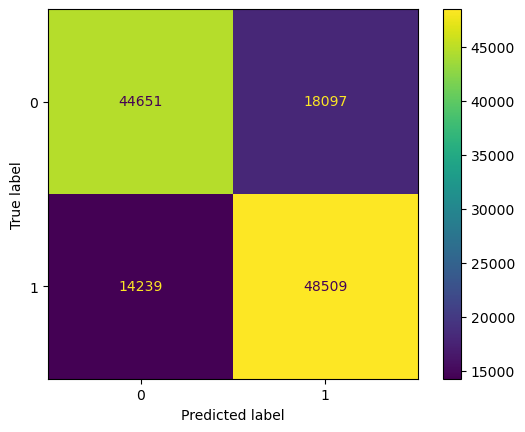

In [6]:

training_predictions = model.predict(X_train)
print(f"Model accuracy: {round(accuracy_score(y_train, training_predictions)*100, 2)}%")
print(classification_report(y_train, training_predictions, zero_division = 0))
ConfusionMatrixDisplay.from_predictions(y_train, training_predictions)


#### Show test metrics.

Model accuracy: 74.49%
              precision    recall  f1-score   support

           0       0.76      0.71      0.74     15687
           1       0.73      0.78      0.75     15687

    accuracy                           0.74     31374
   macro avg       0.75      0.74      0.74     31374
weighted avg       0.75      0.74      0.74     31374



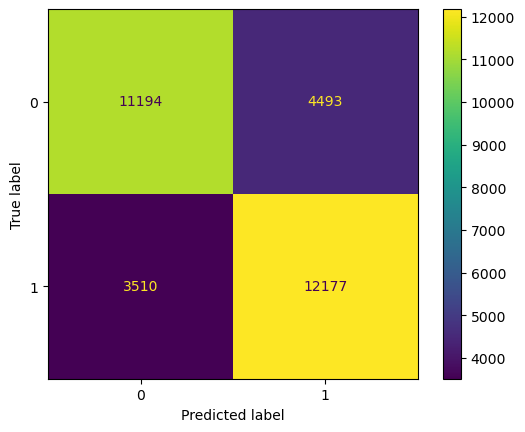

In [7]:

test_predictions = model.predict(X_test)
print(f"Model accuracy: {round(accuracy_score(y_test, test_predictions)*100, 2)}%")
print(classification_report(y_test, test_predictions, zero_division = 0))
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)


#### Show SHAP analysis.

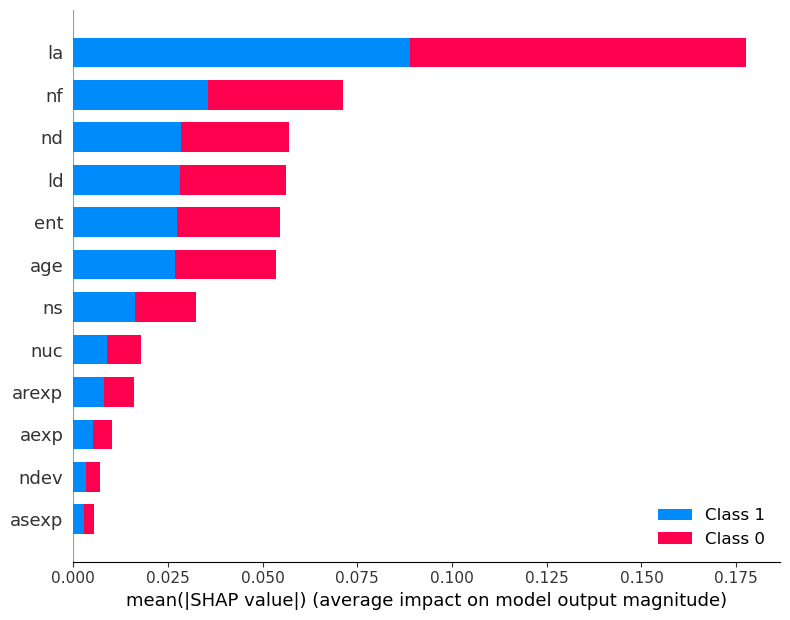

In [8]:

shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type = "bar", feature_names = feature_names)
